In [1]:
import itertools
from datetime import datetime

import submitit 
from pathlib import Path

from auto_circuit.tasks import (
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
)
from auto_circuit_tests.utils import repo_path_to_abs_path, OUTPUT_DIR
from auto_circuit_tests.tasks import IOI_TOKEN_CIRCUIT_TASK
from auto_circuit.types import AblationType
from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Specify Settings / Hyperpameters

In [10]:
#specify the hyperparameters
tasks = [
    IOI_TOKEN_CIRCUIT_TASK, 
    IOI_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    # IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # ANIMAL_DIET_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK
]
use_abs = [True, False] #[True, False]
layerwises = [True, False] # [True, False]
ablation_types = [
    AblationType.RESAMPLE, 
    AblationType.TOKENWISE_MEAN_CLEAN,
    AblationType.TOKENWISE_MEAN_CORRUPT, 
    AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT,
    # AblationType.ZERO
]
grad_funcs = [
    GradFunc.LOGIT, 
    GradFunc.LOGPROB
]
answer_funcs = [
    AnswerFunc.MAX_DIFF, 
    AnswerFunc.AVG_VAL
]

use_abs_to_epsilon = {
    True: [0.1], 
    False: [0.0, -0.4]
}

# generate all combinations
combinations = [
    {
        "task": f"'{task.key}'",
        "use_abs": use_ab,
        "layerwise": layerwise,
        "ablation_type": ablation_type.name,
        "grad_func": grad_func.name,
        "answer_func": answer_func.name,
        "epsilon": epsilon
    }
    for task, use_ab, layerwise, ablation_type, grad_func, answer_func in itertools.product(
        tasks,
        use_abs,
        layerwises,
        ablation_types,
        grad_funcs,
        answer_funcs
    )
    for epsilon in use_abs_to_epsilon[use_ab]
]

In [29]:
# # convert old directory structure to new directory structure 
# # create new task directories
# TEST_RESULTS_DIR = OUTPUT_DIR / 'hypo_test_results_test'
# for task in tasks:
#     # find all directories with task 
#     old_task_dirs = list(TEST_RESULTS_DIR.glob(f"*{task.key.replace(' ', '_')}*"))
#     # create new task directory 
#     task_dir = TEST_RESULTS_DIR / task.key.replace(' ', '_')
#     task_dir.mkdir(exist_ok=True)
#     # move old directories to new directories
#     for old_task_dir in old_task_dirs:
#         old_task_dir.rename(task_dir / old_task_dir.name[len(task.key.replace(' ', '_'))+1:])

# # create new ablation directories
# for task in tasks:
#     task_dir = TEST_RESULTS_DIR / task.key.replace(' ', '_')
#     for ablation_type in ablation_types:
#         # find all directories with ablation type (don't include MEAN_CLEAN_AND_CORRUPT with MEAN_CLEAN)
#         old_ablation_type_dirs = list(task_dir.glob(f"*{ablation_type.name}*"))
#         if ablation_type == AblationType.TOKENWISE_MEAN_CLEAN:
#             old_ablation_type_dirs = [d for d in old_ablation_type_dirs if AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT.name not in d.name]
#         # create new directory 
#         ablation_type_dir = task_dir / ablation_type.name
#         ablation_type_dir.mkdir(exist_ok=True)
#         # move old directories to new directories
#         for old_ablation_type_dir in old_ablation_type_dirs:
#             old_ablation_type_dir.rename(ablation_type_dir / old_ablation_type_dir.name[len(ablation_type.name)+1:-len('_10')])

# # create new prune_score directories
# for task in tasks:
#     task_dir = TEST_RESULTS_DIR / task.key.replace(' ', '_')
#     for ablation_type in ablation_types:
#         ablation_type_dir = task_dir / ablation_type.name
#         grad_answer_dirs = list(ablation_type_dir.iterdir())
#         for grad_answer_dir in grad_answer_dirs:
#             # find all directories 
#             exp_dirs = [d for d in grad_answer_dir.iterdir() if d.is_dir()]
#             # create new directories {ig_samples} and {ig_samples}_layerwise
#             ig_samples_dir = grad_answer_dir / '10'
#             ig_samples_dir.mkdir(exist_ok=True)
#             ig_samples_layerwise_dir = grad_answer_dir / '10_layerwise'
#             ig_samples_layerwise_dir.mkdir(exist_ok=True)
#             # move old directories to new directories
#             for exp_dir in exp_dirs:
#                 if 'layerwise' in exp_dir.name:
#                     exp_dir.rename(ig_samples_layerwise_dir / exp_dir.name.replace('_layerwise', ''))
#                 else:
                    # exp_dir.rename(ig_samples_dir / exp_dir.name)

# Run Activation Patching

In [54]:
act_patch_tasks = [
    IOI_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
]
act_patch_combos = [
    {"task": f"'{task.key}'", "ablation_type": ablation_type.name}
    for task, ablation_type in itertools.product(act_patch_tasks, ablation_types)
]

In [55]:
# setup the executor
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
out_dir.mkdir(exist_ok=True, parents=True)
executor = submitit.AutoExecutor(folder=out_dir)
num_jobs_parallel = 8
executor.update_parameters(
    timeout_min=60*24,
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=4,
    nodes=1,
    slurm_qos="high", 
    slurm_array_parallelism=num_jobs_parallel
)


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [56]:
# run the jobs
with executor.batch():
    jobs = []
    for combo in act_patch_combos:
        function = submitit.helpers.CommandFunction(
            ["python", "compute_act_patch_prune_scores.py"] + [
                f"{key}={value}" for key, value in combo.items()
            ], 
            cwd=repo_path_to_abs_path(".")
        )
        jobs.append(executor.submit(function))

# Setup Executor and Run

In [3]:
# setup the executor
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
out_dir.mkdir(exist_ok=True, parents=True)
executor = submitit.AutoExecutor(folder=out_dir)
num_jobs_parallel = 8
executor.update_parameters(
    timeout_min=60*24,
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=8,
    nodes=1,
    slurm_qos="high", 
    slurm_array_parallelism=num_jobs_parallel
)


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [4]:
# run the jobs
with executor.batch():
    jobs = []
    for combo in combinations:
        function = submitit.helpers.CommandFunction(
            ["python", "find_and_test_circuit.py"] + [
                f"{key}={value}" for key, value in combo.items()
            ], 
            cwd=repo_path_to_abs_path(".")
        )
        jobs.append(executor.submit(function))

In [5]:
jobs[0]

SlurmJob<job_id=450275_0, task_id=0, state="UNKNOWN">

In [6]:
job = jobs[0]
# read stdout and stderr
print(job.stdout())
print(job.stderr())

submitit INFO (2024-09-03 08:33:50,276) - Starting with JobEnvironment(job_id=450275_0, hostname=ddpg.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-09-03 08:33:50,276) - Loading pickle: /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_out_logs/2024-09-03_08-33-47/450275_0_submitted.pkl
The following command is sent: "python find_and_test_circuit.py task='Indirect Object Identification Token Circuit' use_abs=True layerwise=True ablation_type=RESAMPLE grad_func=LOGIT answer_func=MAX_DIFF epsilon=0.1"




# Analyze Results

In [11]:
RESULTS_DIR = OUTPUT_DIR / "hypo_test_aggregated_results"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

## Aggregate Data

In [12]:
from auto_circuit.tasks import Task
def get_exp_dir(
    task_key: str,
    ablation_type: AblationType,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
    ig_samples: int, 
    use_abs: bool,
    alpha: float,
    epsilon: float,
    layerwise: bool,
    q_star: float
):
    exp_path_a = f"{task_key.replace(' ', '_')}_{ablation_type.name}_{grad_func.name}_{answer_func.name}_{ig_samples}"
    exp_path_b = f"{use_abs}_{alpha}_{epsilon}{'_layerwise_' if layerwise else '_'}{q_star}"
    return repo_path_to_abs_path(
        OUTPUT_DIR / "hypo_test_results_old" / exp_path_a / exp_path_b
    )

In [13]:
def format_name(name: str | bool | float | int)->str:
    name = str(name)
    # set to uppercase for processing 
    name = name.upper()
    # remove TOKENWISE
    if name.startswith("TOKENWISE"):
        name = name[len("TOKENWISE_"):]
    # set MIN_EQUIV to NUM_EDGES 
    if name.startswith("MIN_EQUIV"):
        name = name.replace("MIN_EQUIV", "NUM_EDGES")

    # replace GRAD with OUPTUT 
    if name.startswith("GRAD"):
        name = name.replace("GRAD", "OUTPUT")
    # place FUNC with FUNCTION
    if name.endswith("FUNC"):
        name = name.replace("FUNC", "FUNCTION")
    # replace _ with space
    name = name.replace("_", " ")
    # upper case to title case
    name = name.title()
    return name

In [14]:
def format_task_name(task_key: str) -> str:
    task_key = task_key.replace("Indirect Object Identification", "IOI")
    # task_key = task_key.replace("Greater Than", ">")
    task_key = task_key.replace("Circuit", "")
    return task_key

In [15]:
import pandas as pd
import json

ig_default = 10
alpha_default = 0.05
q_star_default = 0.9

# Create a list to store the data
data = []
for combo in combinations:
    task_key = combo["task"][1:-1]  # strip quotes
    ablation_type = AblationType[combo["ablation_type"]]
    grad_func = GradFunc[combo["grad_func"]]
    answer_func = AnswerFunc[combo["answer_func"]]
    use_ab = combo["use_abs"]
    epsilon = combo["epsilon"]
    layerwise = combo['layerwise']

    # get path to results 
    exp_path = get_exp_dir(task_key, ablation_type, grad_func, answer_func, ig_default, use_ab, alpha_default, epsilon, layerwise, q_star_default)

    # load equiv test results 
    with open(exp_path / "equiv_results.json", "r") as f:
        equiv_test_results: dict[int, dict] = json.load(f)
    
    # load min_equiv results
    min_test_path = exp_path / "min_test_results.json"
    if not min_test_path.exists():
        all_minimal = False
        min_mean_p_value = None
    else:
        with open(min_test_path, "r") as f:
            min_equiv_results: dict[int, dict] = json.load(f)
            all_minimal = all(not v['not_minimal'] for v in min_equiv_results.values())
            min_mean_p_value = sum(v['p_value'] for v in min_equiv_results.values()) / len(min_equiv_results)
    
    # load independence results 
    indep_test_path = exp_path / "indep_result.json"
    if not indep_test_path.exists():
        indep = False
    else:
        with open(exp_path / "indep_result.json", "r") as f:
            indep_test_results: dict[int, dict] = json.load(f)
            indep = not indep_test_results["not_indep"]
            indep_p_value = indep_test_results["p_value"]



    total_edges = max([int(edge_count) for edge_count in equiv_test_results.keys()])
    equivs = [int(edge_count) for edge_count, result in equiv_test_results.items() if not result["not_equiv"]]
    min_equiv = min(equivs) if len(equivs) > 0 else total_edges

    # Append the data as a dictionary
    data.append({
        'task_key': task_key,
        'token': "Token" in task_key,  # New index token
        'use_abs': use_ab,
        'epsilon': epsilon,
        'layerwise': layerwise,
        'ablation_type': ablation_type.name,
        'answer_func': answer_func.name,
        'grad_func': grad_func.name,
        'frac_total_edges': min_equiv / total_edges,
        'min_equiv': min_equiv,
        'total_edges': total_edges, 
        'all_minimal': all_minimal, 
        'min_mean_p_value': min_mean_p_value,
        'indep': indep, 
        'indep_p_value': indep_p_value

    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Set a multi-index
df.set_index(['task_key', 'token', 'use_abs', 'epsilon', 'layerwise', 'ablation_type', 'answer_func', 'grad_func'], inplace=True)

In [16]:
df

frac_total_edges  \
task_key                                     token use_abs epsilon layerwise ablation_type                    answer_func grad_func                     
Indirect Object Identification Token Circuit True  True     0.1    True      RESAMPLE                         MAX_DIFF    LOGIT              0.215181   
                                                                                                              AVG_VAL     LOGIT              0.138978   
                                                                                                              MAX_DIFF    LOGPROB            0.215181   
                                                                                                              AVG_VAL     LOGPROB            0.133781   
                                                                             TOKENWISE_MEAN_CLEAN             MAX_DIFF    LOGIT              0.004179   
...                                                                                                                                               ...   
Greaterthan Component Circuit                False False   -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGIT              1.000000   
                                                            0.0    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT MAX_DIFF    LOGPROB            0.002955   
                                                           -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT MAX_DIFF    LOGPROB            1.000000   
                                                            0.0    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGPROB            0.000215   
                                                           -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGPROB            1.000000   

                                                                                                                                     min_equiv  \
task_key                                     token use_abs epsilon layerwise ablation_type                    answer_func grad_func              
Indirect Object Identification Token Circuit True  True     0.1    True      RESAMPLE                         MAX_DIFF    LOGIT          90889   
                                                                                                              AVG_VAL     LOGIT          58702   
                                                                                                              MAX_DIFF    LOGPROB        90889   
                                                                                                              AVG_VAL     LOGPROB        56507   
                                                                             TOKENWISE_MEAN_CLEAN             MAX_DIFF    LOGIT           1765   
...                                                                                                                                        ...   
Greaterthan Component Circuit                False False   -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGIT          32491   
                                                            0.0    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT MAX_DIFF    LOGPROB           96   
                                                           -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT MAX_DIFF    LOGPROB        32491   
                                                            0.0    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGPROB            7   
                                                           -0.4    False     TOKENWISE_MEAN_CLEAN_AND_CORRUPT AVG_VAL     LOGPROB        32491   

                                                                                                                                     total_edges  \
task_key                                     token use_abs epsilon layerwise ablation_type      

In [17]:
# TODO: just add df, results to to repo, reference in paper
df.to_csv(RESULTS_DIR / "hypo_test_results.csv")
df_pretty = df.copy()

# rename 
df_pretty.rename(index=format_name, inplace=True, level='answer_func')
df_pretty.rename(index=format_name, inplace=True, level='grad_func')
df_pretty.rename(index=format_name, inplace=True, level='ablation_type')
df_pretty.rename(index=format_task_name, inplace=True, level='task_key')

# add token vs component index 
df = df_pretty
df.head()
# df_pretty.rename(index="{:.1f}".format, inplace=True, level='epsilon')
# df_pretty.columns = [format_name(col) for col in df_pretty.columns]
# df_pretty.index.names = [format_name(col) for col in df_pretty.index.names]


frac_total_edges  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func                     
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit              0.215181   
                                                         Avg Val     Logit              0.138978   
                                                         Max Diff    Logprob            0.215181   
                                                         Avg Val     Logprob            0.133781   
                                           Mean Clean    Max Diff    Logit              0.004179   

                                                                                min_equiv  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func              
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit          90889   
                                                         Avg Val     Logit          58702   
                                                         Max Diff    Logprob        90889   
                                                         Avg Val     Logprob        56507   
                                           Mean Clean    Max Diff    Logit           1765   

                                                                                total_edges  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func                
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit           422383   
                                                         Avg Val     Logit           422383   
                                                         Max Diff    Logprob         422383   
                                                         Avg Val     Logprob         422383   
                                           Mean Clean    Max Diff    Logit           422383   

                                                                                all_minimal  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func                
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit            False   
                                                         Avg Val     Logit            False   
                                                         Max Diff    Logprob          False   
                                                         Avg Val     Logprob          False   
                                           Mean Clean    Max Diff    Logit            False   

                                                                                min_mean_p_value  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func                     
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit              0.350339   
                                                         Avg Val     Logit              0.234907   
                                                         Max Diff    Logprob            0.352463   
                                                         Avg Val     Logprob            0.452086   
                                           Mean Clean    Max Diff    Logit              0.139048   

                                                                                indep  \
task_key   token use_abs epsilon layerwise ablation_type answer_func grad_func          
IOI Token  True  True    0.1     True      Resample      Max Diff    Logit      False   
                                                         Avg Val     Logit      False   
                                                         Max Diff    Logprob    False   
                                                         Avg Val     Logprob    False   
                                           Mean Clean    Max Diff    Logit       True   

                                                                      

## Edge Counts for all Tasks, All Partitions

In [9]:
from typing import Literal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, VPacker
import numpy as np
import itertools
from pathlib import Path

def plot_fraction_edges(
    df, 
    dir: Path, 
    fontsize=12, 
    cutoff=0.5,
    scale: Literal['log', 'linear'] = 'log', 
    figsize=(16, 15),
    dpi=100,
    figname='fraction_edges.png'
):
    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    use_abs_eps = df.index.droplevel([level for level in df.index.names if level not in ['use_abs', 'epsilon']]).drop_duplicates().to_list()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    # Create a single figure with three subplots (rows)
    fig, axs = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True)

    all_handles = []
    all_labels = []
    
    for row, (use_ab, epsilon) in enumerate(use_abs_eps[:3]):  # Limit to first 3 combinations
        ax = axs[row]
        print(f"Row {row + 1}: use_abs={use_ab}, epsilon={epsilon}")
        
        index = np.arange(len(task_keys))
        bar_width = 0.8 / len(ablation_answer_combinations)
        opacity = 0.8

        plotted_combinations = 0  # Counter for actually plotted combinations

        for i, combination in enumerate(ablation_answer_combinations):
            ablation_type, answer_func, grad_func = combination

            # Filter the DataFrame
            mask = (df.index.get_level_values('use_abs') == use_ab) & \
                    (df.index.get_level_values('epsilon') == epsilon) & \
                    (df.index.get_level_values('ablation_type') == ablation_type) & \
                    (df.index.get_level_values('answer_func') == answer_func) & \
                    (df.index.get_level_values('grad_func') == grad_func)

            subset = df[mask]

            values = subset['frac_total_edges'].values
            edge_counts = subset['min_equiv'].values
            minimal = subset['all_minimal'].values
            indep = subset['indep'].values
            task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])

            position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width

            bars = ax.bar(position, values, bar_width,
                    alpha=opacity,
                    label=f'{ablation_type} & {answer_func} & {grad_func}')


            # Collect handles and labels for the legend
            if row == 0:  # Only collect once
                all_handles.append(bars[0])
                all_labels.append(f'{ablation_type} & {answer_func} & {grad_func}')

            # add symbols above bars for minimal and independent 
            minimal_marker = f'✔'
            indep_marker = f'○'
            marker_fontsize = 24
            for bar, edge_count, is_minimal, is_indep in zip(bars, edge_counts, minimal, indep):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()

                if is_minimal and is_indep:
                    ax.text(x, y, f'{minimal_marker}\n{indep_marker}', ha='center', va='top', fontsize=marker_fontsize, linespacing=0.8)
                elif is_minimal:
                    ax.text(x, y, minimal_marker, ha='center', va='top', fontsize=marker_fontsize)
                elif is_indep:
                    ax.text(x, y, indep_marker, ha='center', va='top', fontsize=marker_fontsize)

            plotted_combinations += 1

        # add dotted line at cutoff
        cutoff_line = ax.axhline(y=cutoff, color='black', linestyle='--', label=f'cutoff={cutoff}', alpha=0.5)
        if row == 0:
            all_handles.append(cutoff_line)
            all_labels.append(f'cutoff={cutoff}')
        if row == 1:
            ax.set_ylabel('Fraction of Total Edges', fontsize=fontsize)
        ax.set_title(f'Use Abs={use_ab}, Epsilon={epsilon}', fontsize=fontsize)
        ax.set_xticks(index)
        ax.set_xticklabels(task_keys, rotation=15, ha='center', fontsize=fontsize)
        ax.set_yscale(scale)
        ax.tick_params(axis='y', labelsize=fontsize)

    # Add Minimal and Independent symbols to the legend
    all_labels.extend([f'{minimal_marker} Minimal', f'{indep_marker} Independent'])
    all_handles.extend([plt.Rectangle((0,0),1,1,fc="white", ec="white", lw=0, alpha=0)]*2)
     # Create a figure-level legend
    fig.legend(handles=all_handles, labels=all_labels, 
        bbox_to_anchor=(0.5, -0.70), 
        loc='lower center', 
        # borderaxespad=0., 
        fontsize=fontsize-2,
        # ncol=1, 
        # handletextpad=0.5
    )

    plt.tight_layout()
    # plt.subplots_adjust(right=0.75)

    fig, axs = limit_image_size(fig, axs)

    plt.savefig(dir / figname, 
                bbox_inches='tight', 
                dpi=100)
    plt.close(fig)

    print("Figure with three rows has been generated and saved.")

# Usage
df_no_layerwise = df.xs(False, level='layerwise', drop_level=False)
plot_fraction_edges(df_no_layerwise, fontsize=45, dir=RESULTS_DIR, figsize=(30, 25), dpi=200, figname='fraction_edges.png')

Row 1: use_abs=True, epsilon=0.1
Figure with three rows has been generated and saved.


In [10]:
df_layerwise = df.xs(True, level='layerwise', drop_level=False)
plot_fraction_edges(df_layerwise, fontsize=45, dir=RESULTS_DIR, figsize=(30, 25), dpi=200, figname='fraction_edges_layerwise.png')

Row 1: use_abs=True, epsilon=0.1
Figure with three rows has been generated and saved.


In [11]:
from typing import Literal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from  matplotlib.offsetbox import TextArea, VPacker
import numpy as np
import itertools

def plot_fraction_edges(
    df, 
    dir: Path, 
    fontsize=12, 
    cutoff=0.5,
    scale: Literal['log', 'linear'] = 'log', 
    figsize=(16, 9),
    dpi=100
):

    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    use_abs_eps = df.index.droplevel([level for level in df.index.names if level not in ['use_abs', 'epsilon']]).drop_duplicates().to_list()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    for use_ab, epsilon in use_abs_eps:
        print(epsilon)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        index = np.arange(len(task_keys))
        bar_width = 0.8 / len(ablation_answer_combinations)
        opacity = 0.8

        plotted_combinations = 0  # Counter for actually plotted combinations

        for i, combination in enumerate(ablation_answer_combinations):
            ablation_type, answer_func, grad_func = combination
            
            # Filter the DataFrame
            mask = (df.index.get_level_values('use_abs') == use_ab) & \
                    (df.index.get_level_values('epsilon') == epsilon) & \
                    (df.index.get_level_values('ablation_type') == ablation_type) & \
                    (df.index.get_level_values('answer_func') == answer_func) & \
                    (df.index.get_level_values('grad_func') == grad_func)
            
            subset = df[mask]
            
            # if not subset.empty:
            values = subset['frac_total_edges'].values
            edge_counts = subset['min_equiv'].values
            minimal = subset['all_minimal'].values
            indep = subset['indep'].values
            task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])
            
            position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width
            
            bars = ax.bar(position, values, bar_width,
                    alpha=opacity,
                    label=f'{ablation_type} & {answer_func} & {grad_func}')
            
            # add symbols above bars for minimal and independent 
            minimal_marker = f'✔'
            indep_marker = f'○'
            for bar, edge_count, is_minimal, is_indep in zip(bars, edge_counts, minimal, indep):
                # Calculate the position for symbols
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                
                if is_minimal and is_indep:
                    # If both symbols are present, stack them
                    ax.text(x, y, f'{minimal_marker}\n{indep_marker}', ha='center', va='top', fontsize=8, linespacing=0.8)
                elif is_minimal:
                    # Only minimal check
                    ax.text(x, y, minimal_marker, ha='center', va='top', fontsize=8)
                elif is_indep:
                    # Only independence circle
                    ax.text(x, y, indep_marker, ha='center', va='top', fontsize=8)
            
            plotted_combinations += 1

        if plotted_combinations == 0:
            plt.close(fig)
            continue  # Skip to the next iteration if no data was plotted
        
        # add dotted line at cutoff
        ax.axhline(y=cutoff, color='black', linestyle='--', label=f'cutoff={cutoff}', alpha=0.5)

        # ax.set_xlabel('Tasks')
        ax.set_ylabel('Fraction of Total Edges', fontsize=fontsize)
        ax.set_title(f'Fraction of Total Edges by Task (Use Abs={use_ab}, Epsilon={epsilon})', fontsize=fontsize)
        ax.set_xticks(index)
        ax.set_xticklabels(task_keys, rotation=0, ha='center', fontsize=fontsize)


        # Legend
        # Get the existing legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Add text entries for Minimal and Independent to the legend
        labels.extend([f'{minimal_marker} Minimal', f'{indep_marker} Independent'])
        handles.extend([plt.Rectangle((0,0),1,1,fc="white", ec="white", lw=0, alpha=0)]*2)  # Invisible rectangles as placeholders

        # Add the combined legend to the plot
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=fontsize)

        ax.set_yscale(scale)
        
        plt.tight_layout()
        plt.subplots_adjust(right=0.75)
        
        fig, ax = limit_image_size(fig, ax)
        
        plt.savefig(dir / f'fraction_edges_use_ab_{use_ab}_epsilon_{epsilon}.png', 
                    bbox_inches='tight', 
                    dpi=100)
        plt.close(fig)

    print("All figures have been generated and saved.")

# Usage
plot_fraction_edges(df_no_layerwise, dir=RESULTS_DIR, figsize=(16, 5))

0.1
All figures have been generated and saved.


## Interaction Effects via OLS and ANOVA

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations
from scipy import stats

def run_anova_with_interactions(
    df, 
    response, 
    factors, 
    anova_type=3, 
    robust='hc3'
):
    # Reset index to make all features accessible
    df_reset = df.reset_index()
    
    # Create formula for the model
    main_effects = " + ".join([f"C({f})" for f in factors])
    two_way_interactions = " + ".join([f"C({f1}):C({f2})" for f1, f2 in combinations(factors, 2)])
    formula = f"{response} ~ {main_effects} + {two_way_interactions}"
    
    # TODO: make sure (or ensure) that the factors are categorical
    # Fit OLS model
    model = ols(formula, data=df_reset).fit()

    # TODO: debug this, make sure categorical is functioning properly
    # Calculate effect sizes (partial eta-squared)
    anova_table = sm.stats.anova_lm(model, typ=anova_type, robust=robust)
    anova_table['partial_eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table['sum_sq'].iloc[-1])
    
    return anova_table, model

# Assuming df is your DataFrame
features = ['task_key', 'epsilon', 'ablation_type', 'answer_func', 'grad_func']
response = 'frac_total_edges'

# Run robust regression with interactions
anova_table, model = run_anova_with_interactions(df, response, features)

# print("Robust Regression Results:")
# print(summary_table)

print("\nANOVA Table with Effect Sizes:")
anova_table.sort_values('PR(>F)', ascending=True)
print(anova_table)


ANOVA Table with Effect Sizes:
                                    sum_sq     df           F        PR(>F)  \
Intercept                         8.018406    1.0  152.212942  4.381625e-30   
C(task_key)                      27.432137    4.0  130.185672  2.292117e-72   
C(epsilon)                        2.180417    2.0   20.695366  2.661448e-09   
C(ablation_type)                  0.684993    3.0    4.334394  5.036825e-03   
C(answer_func)                    0.563843    1.0   10.703393  1.157015e-03   
C(grad_func)                      0.003993    1.0    0.075808  7.831949e-01   
C(task_key):C(epsilon)           14.583572    8.0   34.604891  5.820844e-42   
C(task_key):C(ablation_type)      4.866058   12.0    7.697675  5.632674e-13   
C(task_key):C(answer_func)        1.411216    4.0    6.697260  3.112053e-05   
C(task_key):C(grad_func)          0.053375    4.0    0.253303  9.076062e-01   
C(epsilon):C(ablation_type)       0.949463    6.0    3.003934  6.934645e-03   
C(epsilon):C(answer_

we use type 3 anova b/c no hierarchical structure and care about interactions, 
hc3 to correct heteroscedasticity in variance

In [30]:
import matplotlib.pyplot as plt
import scipy.stats as stats
def check_anova_assumptions(model, df):
    df_reset = df.reset_index()
    # 1. Normality of residuals
    residuals = model.resid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title("Q-Q plot of residuals")
    
    # Histogram
    ax2.hist(residuals, bins=20)
    ax2.set_title("Histogram of residuals")
    plt.show()
    
    # Shapiro-Wilk test
    _, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value: {p_value}")
    print("If p-value > 0.05, residuals are likely normally distributed.")
    
    # 2. Homogeneity of variances (Levene's test)
    # We'll check this for each categorical variable
    for feature in features:
        groups = df_reset.groupby(feature)['frac_total_edges']
        levene_statistic, levene_p_value = stats.levene(*[group for name, group in groups])
        print(f"\nLevene's test for {feature}:")
        print(f"Statistic: {levene_statistic}, p-value: {levene_p_value}")
        print("If p-value > 0.05, variances are likely homogeneous.")
    
    # 3. Independence of observations
    # This is typically ensured by the experimental design and cannot be tested statistically.
    # We'll create a plot of residuals vs. fitted values to check for patterns
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, residuals)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted Values")
    plt.show()
    print("\nCheck the 'Residuals vs Fitted Values' plot for any patterns.")
    print("If no clear pattern is visible, the independence assumption is likely met.")


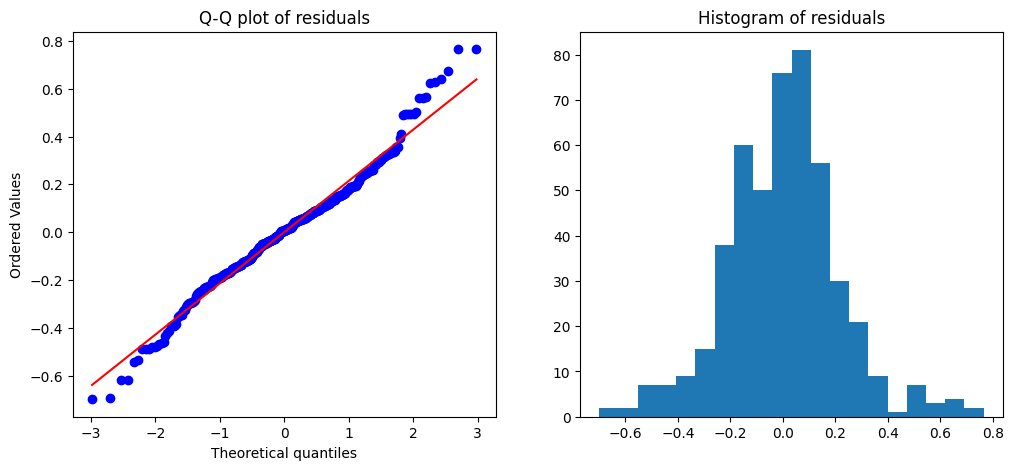

Shapiro-Wilk test p-value: 1.0840868301715222e-05
If p-value > 0.05, residuals are likely normally distributed.

Levene's test for task_key:
Statistic: 14.757240751138719, p-value: 2.2567810092205456e-11
If p-value > 0.05, variances are likely homogeneous.

Levene's test for epsilon:
Statistic: 6.469986916019045, p-value: 0.0016887205742831834
If p-value > 0.05, variances are likely homogeneous.

Levene's test for ablation_type:
Statistic: 0.8381975485892678, p-value: 0.47337758521299
If p-value > 0.05, variances are likely homogeneous.

Levene's test for answer_func:
Statistic: 13.951166452860717, p-value: 0.0002102590148110518
If p-value > 0.05, variances are likely homogeneous.

Levene's test for grad_func:
Statistic: 0.0006322925458362601, p-value: 0.9799494592160065
If p-value > 0.05, variances are likely homogeneous.


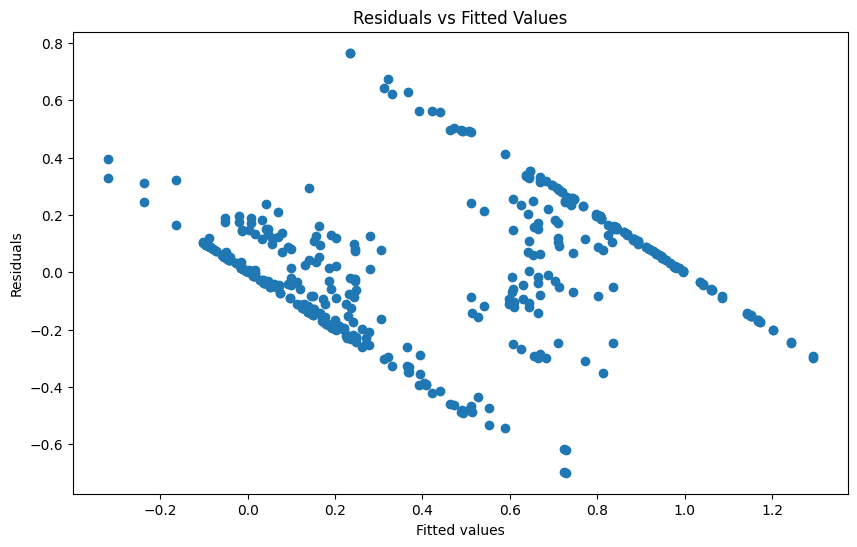


Check the 'Residuals vs Fitted Values' plot for any patterns.
If no clear pattern is visible, the independence assumption is likely met.


In [31]:
check_anova_assumptions(model, df)

In [84]:
def format_factor(factor: str) -> str:
    factor = factor.replace("C(", "").replace(")", "")
    factors = factor.split(":")
    factors = [format_name(f) for f in factors]
    return " x ".join(factors)
def custom_float_format(x):
    if abs(x) < 1e-3 and x != 0:
        return f"{x:.0e}"
    else:
        return f"{x:.3f}"

In [85]:
anova_table_pretty = anova_table.copy()
anova_table_pretty.index = [format_factor(factor) for factor in anova_table_pretty.index]
# convert df to int
# anova_table = anova_table.astype({'df': int})
# remove sum_square and df column
anova_table_pretty = anova_table_pretty.drop(columns=['df', 'sum_sq'])
print(anova_table_pretty.sort_values('PR(>F)', ascending=True).to_latex(float_format=custom_float_format))

\begin{tabular}{lrrr}
\toprule
 & F & PR(>F) & partial_eta_sq \\
\midrule
Task Key & 47.353 & 3e-27 & 0.509 \\
Task Key x Epsilon & 17.339 & 4e-19 & 0.431 \\
Intercept & 55.454 & 4e-12 & 0.233 \\
Task Key x Ablation Type & 3.464 & 1e-04 & 0.185 \\
Epsilon & 9.362 & 1e-04 & 0.093 \\
Epsilon x Ablation Type & 2.699 & 0.016 & 0.081 \\
Answer Function & 3.554 & 0.061 & 0.019 \\
Ablation Type x Answer Function & 1.905 & 0.130 & 0.030 \\
Ablation Type & 1.884 & 0.134 & 0.030 \\
Task Key x Answer Function & 1.478 & 0.211 & 0.031 \\
Epsilon x Answer Function & 0.643 & 0.527 & 0.007 \\
Output Function & 0.183 & 0.669 & 0.001 \\
Ablation Type x Output Function & 0.407 & 0.748 & 0.007 \\
Answer Function x Output Function & 0.071 & 0.790 & 4e-04 \\
Epsilon x Output Function & 0.085 & 0.918 & 9e-04 \\
Task Key x Output Function & 0.073 & 0.990 & 0.002 \\
Residual & NaN & NaN & 0.500 \\
\bottomrule
\end{tabular}



## Relative Edge Counts Across Joint Configurations

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', 'median', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns, including phantom columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a red point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3, marker='o')
        
        # Plot median with a green triangle
        ax.scatter(x_positions[i], row['median'], color='green', s=100, zorder=3, marker='^')
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, marker='o', label='Mean')
    ax.scatter([], [], color='green', s=100, marker='^', label='Median')
    ax.legend()
    
    plt.tight_layout()
    # plt.show()

    return fig, ax

### By Ablation Type

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by ablation_type'}, xlabel='ablation_type', ylabel='Normalized frac_total_edges'>)

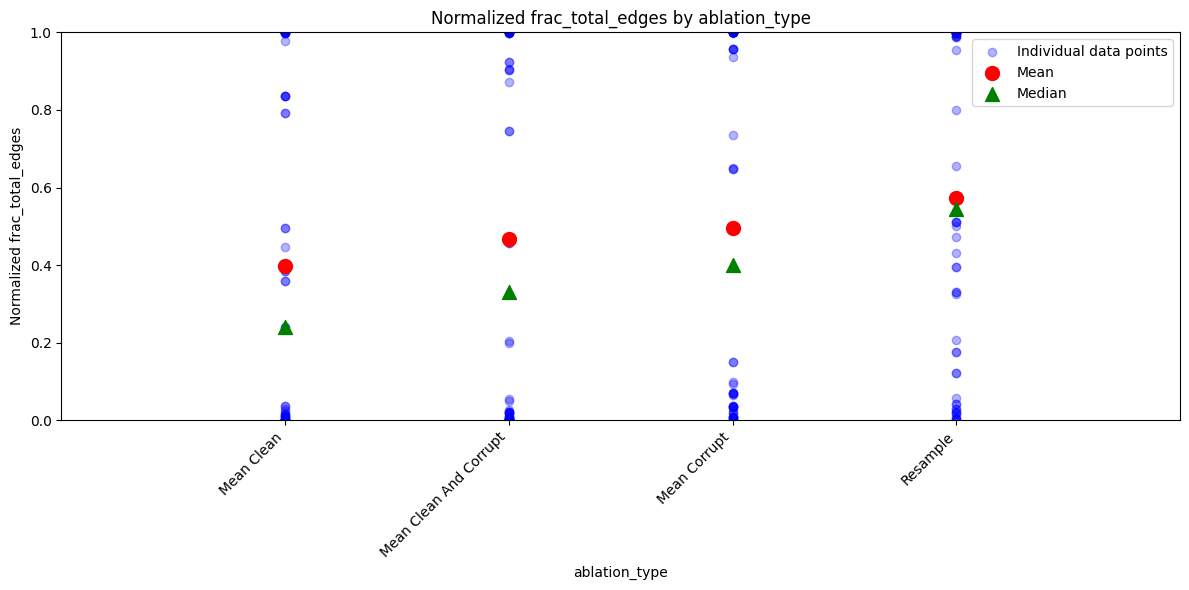

In [16]:
# Example usage:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right', 
)

thoughts - no clear winner, not too much data, though the fact that mean corrupt tends to be smaller does make sense (doesn't need to infer task)

### By Output Function (LogProb vs Logit)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by grad_func'}, xlabel='grad_func', ylabel='Normalized frac_total_edges'>)

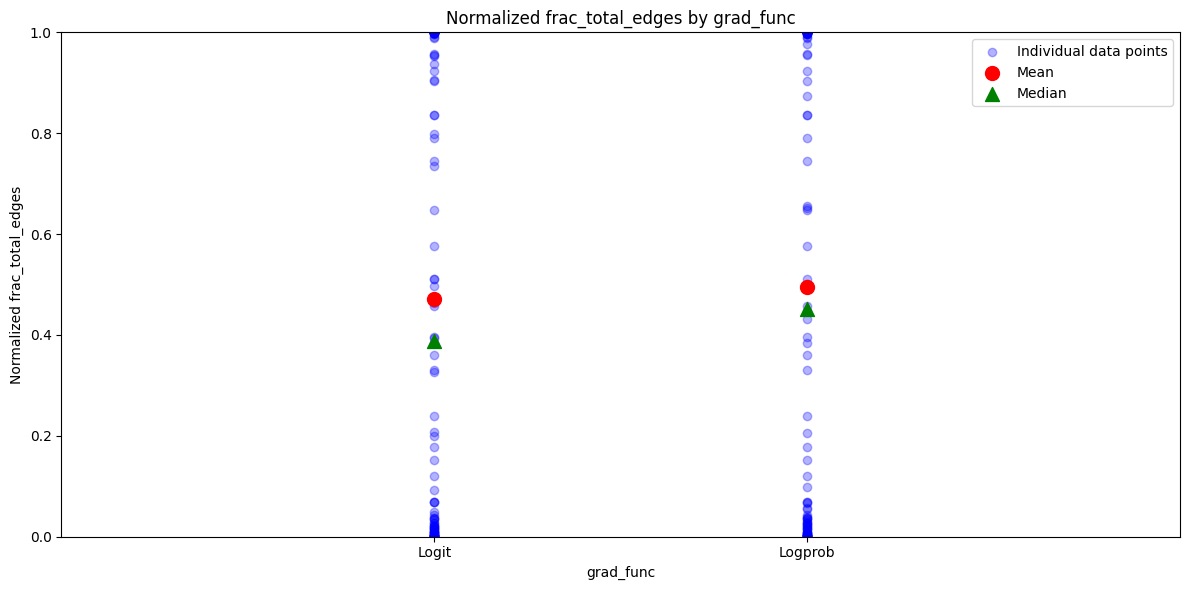

In [17]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

obviously no clear winners, but lots of variation

### Compare Answer Functions 

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by answer_func'}, xlabel='answer_func', ylabel='Normalized frac_total_edges'>)

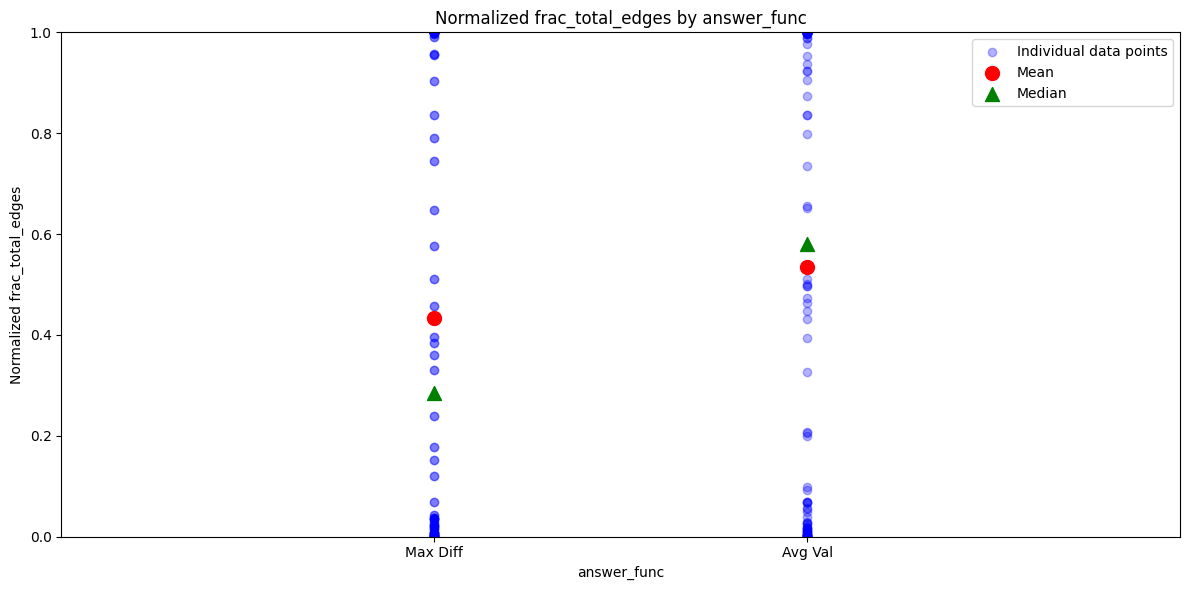

In [18]:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

I guess I would have predicted max diff would have more of an advantage - maybe I should be looking at token only? idk

### Output Function x Answer Function

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by grad_func and answer_func'}, xlabel='grad_func and answer_func', ylabel='Normalized frac_total_edges'>)

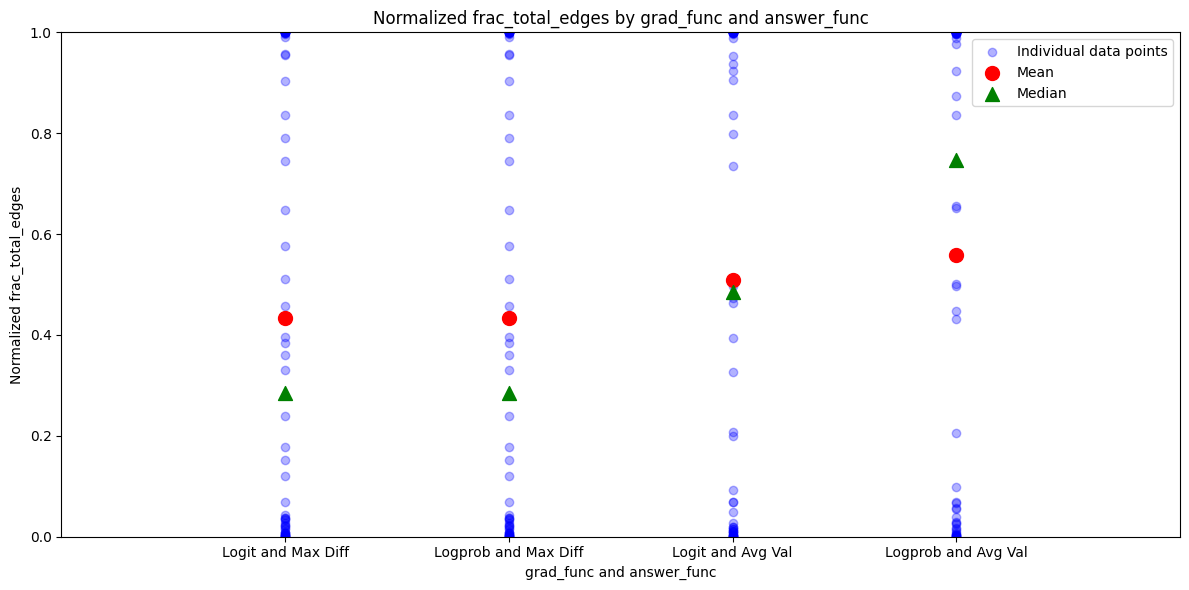

In [19]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

### Output Function x Answer Function x Ablation Type 

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by grad_func and answer_func and ablation_type'}, xlabel='grad_func and answer_func and ablation_type', ylabel='Normalized frac_total_edges'>)

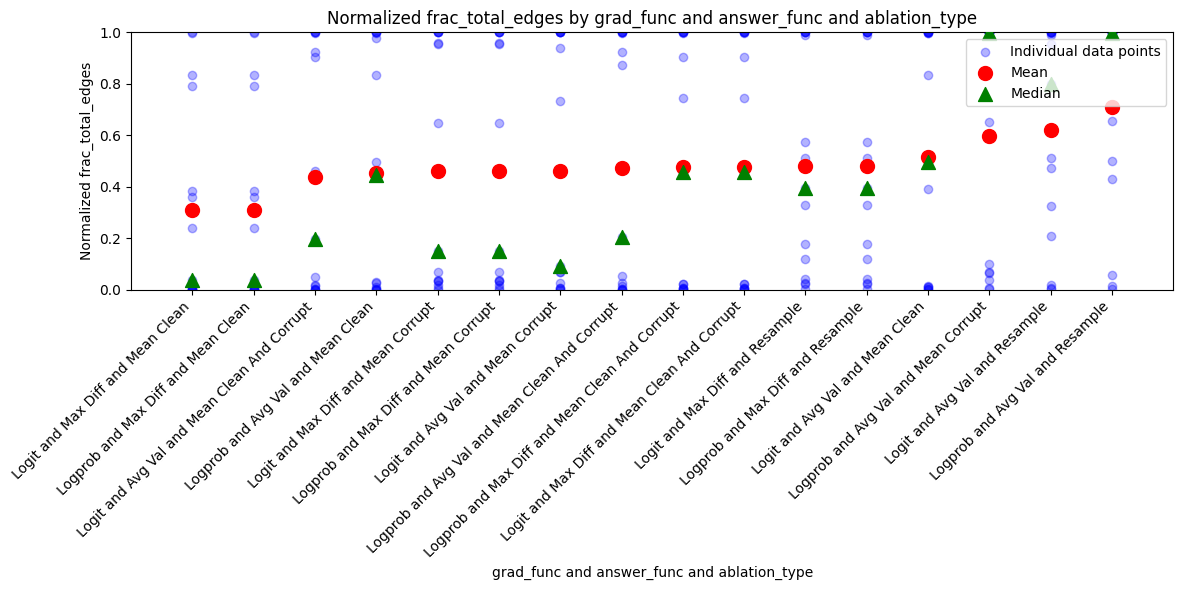

In [20]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func', 'ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right'
)

ok I could probably stare at it more but no super discernable synergies, seems like some methods are marignally "better", those difference roughly compound

### Abs vs Postive Only
What I want - aggregatae across 

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by use_abs (Filtered: epsilon≠[-0.4])'}, xlabel='use_abs', ylabel='Normalized frac_total_edges'>)

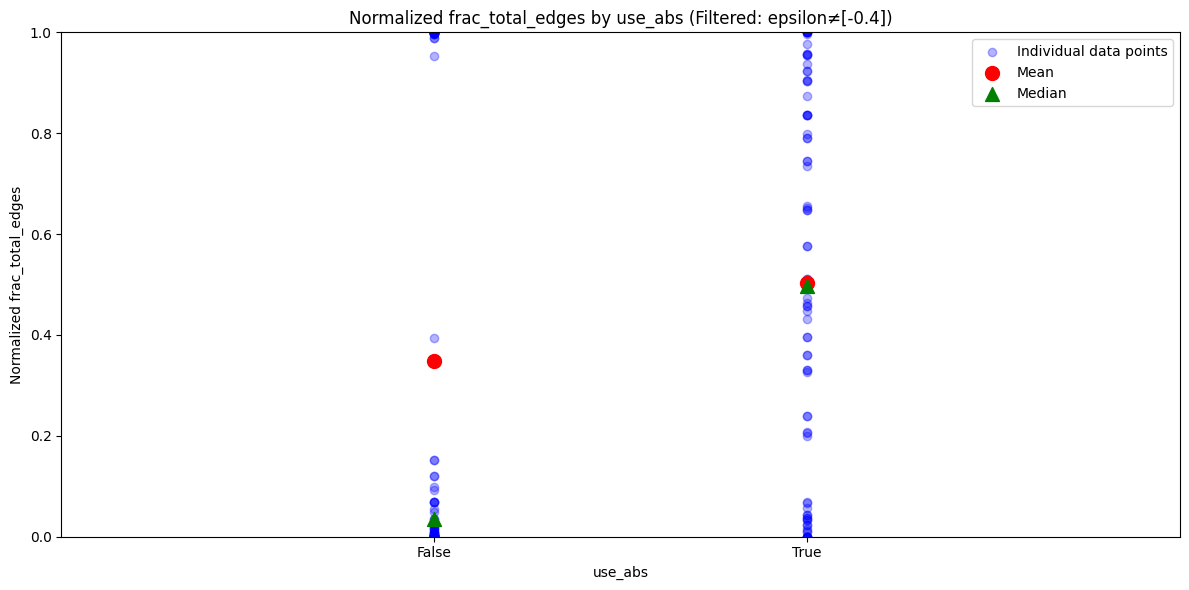

In [21]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['use_abs'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [-0.4]}
)

### Abs 0.0 vs 0.4 

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized frac_total_edges by epsilon (Filtered: epsilon≠[0.1])'}, xlabel='epsilon', ylabel='Normalized frac_total_edges'>)

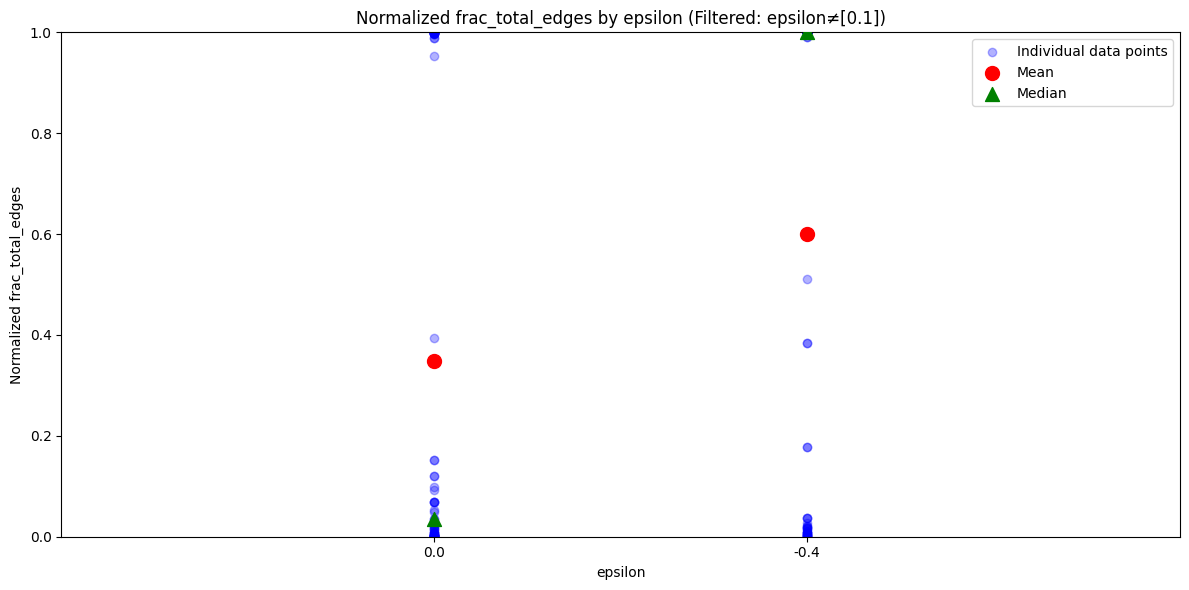

In [22]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['epsilon'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [0.1]}
)

## Relative Edge Counts Marginalized Across Single Configuration

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any
import pandas as pd

def flexible_normalize_and_plot_categories(
    df: pd.DataFrame,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    custom_filters: Dict[str, List] = None,
    figsize: tuple = (20, 10),
    n_cols: int = 3,
    show_individual_points: bool = True,
    show_std_dev: bool = False
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(agg_by)
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex='col', sharey='row', squeeze=False)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Calculate font sizes based on figsize
    title_fontsize = figsize[0] * 1.2
    label_fontsize = figsize[0] * 1.5
    y_axis_fontsize = figsize[0] * 1.5
    tick_fontsize = figsize[0] * 1.5
    legend_fontsize = figsize[0] * 1.2
    
    # Calculate marker sizes based on figsize
    individual_marker_size = figsize[0] * 30
    mean_median_marker_size = figsize[0] * 60
    
    # Create a scatter plot for each category
    for i, category in enumerate(agg_by):
        ax = axes[i]
        
        # Aggregate data for this category
        agg_data = df_reset.groupby(category)[f'normalized_{value_column}'].agg(['mean', 'median', 'std', list]).reset_index()
        agg_data = agg_data.sort_values('mean', ascending=True)
        
        # Calculate x-positions for evenly spaced columns
        num_columns = len(agg_data)
        x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
        
        for j, (_, row) in enumerate(agg_data.iterrows()):
            # Plot individual points with reduced opacity if show_individual_points is True
            if show_individual_points:
                ax.scatter([x_positions[j]] * len(row['list']), row['list'], alpha=0.3, color='blue', s=individual_marker_size)
            
            # Plot mean with a red point
            ax.scatter(x_positions[j], row['mean'], color='red', s=mean_median_marker_size, zorder=3, marker='o')
            
            # Plot median with a green triangle
            ax.scatter(x_positions[j], row['median'], color='green', s=mean_median_marker_size, zorder=3, marker='^')
            
            # Plot standard deviation if show_std_dev is True
            if show_std_dev:
                ax.errorbar(x_positions[j], row['mean'], yerr=row['std'], color='black', capsize=figsize[0]*0.5, capthick=figsize[0]*0.2, fmt='none', zorder=2)
        
        # Set title and labels
        ax.set_xlabel(format_name(category), fontsize=label_fontsize)
        ax.xaxis.set_label_position('top')
        if i % n_cols == 0:  # Only set ylabel for the leftmost subplot in each row
            ax.set_ylabel(f'Normalized {format_name(value_column)}', fontsize=y_axis_fontsize)
        
        # Set x-ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(agg_data[category].map(format_name), rotation=45, ha='right', fontsize=tick_fontsize)
        
        # Set axis limits
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(0, 1.05)
        
        # Remove box around the plot
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a legend to the figure
    legend_elements = []
    if show_individual_points:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Individual data points',
                                          markerfacecolor='blue', markersize=figsize[0]*0.6, alpha=0.3))
    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='w', label='Mean', markerfacecolor='red', markersize=figsize[0]*0.8),
        plt.Line2D([0], [0], marker='^', color='w', label='Median', markerfacecolor='green', markersize=figsize[0]*0.8)
    ])
    if show_std_dev:
        legend_elements.append(plt.Line2D([0], [0], color='black', label='Standard Deviation'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15), fontsize=legend_fontsize)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    return fig, axes

In [ ]:
# TODO: how to fit this into AAAI template (probably just rotate is the best bet for now?)

# Example usage:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    n_cols=5,
    agg_by=['ablation_type', 'answer_func', 'grad_func', 'token'],
    value_column='min_equiv',
    normalize_by=['task_key', 'epsilon'],
    figsize=(120,45),
    # n_cols=3
)

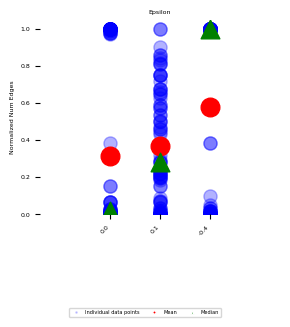

In [122]:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    agg_by=['epsilon'],
    value_column='min_equiv',
    normalize_by=['task_key'],
    figsize=(3, 3),
    n_cols=1
)

## Minimality and Completeness Statistics

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

def create_category_pie_charts(
    data, 
    title: str, 
    ignore_categories=None, 
    figsize=(20, 15), 
    n_cols=3,
    fontsize=90, 
    legend_fontsize=78,
    cat_fontsize=96,
    title_fontsize=48,
    legend_bbox_to_anchor=(0.5, -0.6),
    hspace=0.5
):
    """
    Create a grid of pie charts, one for each category in the data.
    
    :param data: A pandas DataFrame with a multi-index as described in the input data.
    :param ignore_categories: Optional list of categories to ignore in the charts.
    :param figsize: Tuple specifying the figure size (width, height).
    :param fontsize: Font size for the title and subplot titles.
    :return: None (displays the charts)
    """
    if ignore_categories is None:
        ignore_categories = []
    
    # Get all categories (index names)
    categories = [cat for cat in data.index.names if cat not in ignore_categories]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(categories)
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(title, fontsize=title_fontsize)  # Increased font size for main title
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Create a pie chart for each category
    for i, category in enumerate(categories):
        ax = axes[i]
        
        # Get value counts and calculate fractions
        value_counts = data.groupby(level=category).size()
        fractions = value_counts / value_counts.sum()
        
        # apply format names to fractions
        fractions.index = fractions.index.map(format_name)
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(fractions, autopct='%1.0f%%', textprops=dict(color="w", fontsize=fontsize))  # Increased font size for percentages
        
        # Add category name as title
        ax.set_title(format_name(category), fontsize=cat_fontsize)  # Increased font size for subplot titles
        
        # Add legend
        ax.legend(wedges, fractions.index, 
                  loc="upper center", 
                  bbox_to_anchor=legend_bbox_to_anchor, 
                  fontsize=legend_fontsize  # Increased font size for legend
        )
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)  # Adjust this value as needed
    plt.show()

In [24]:
# minimal circuits
minimal_df = df[df['all_minimal']]
true_minimal_df = minimal_df[minimal_df['frac_total_edges'] < 0.5] # likely minimal b/c complement edges very small impact, not counting for now
true_minimal_tested_df = true_minimal_df[true_minimal_df['min_equiv'] <= 500] # minimal circuits fully tested (we only test up to 500 edges)
true_mimimal_untested = true_minimal_df[true_minimal_df['min_equiv'] > 500] # minimal circuits not fully tested (TODO test)

In [25]:
len(minimal_df), len(true_minimal_df), len(true_minimal_tested_df), len(true_mimimal_untested)

(124, 92, 74, 18)

In [26]:
# independent circuits 
indep_df = df[df['indep']]
indep_and_true_minimal_df = indep_df[indep_df.index.isin(true_minimal_df.index)]
indep_and_true_tested_minimal_df = indep_df[indep_df.index.isin(true_minimal_tested_df.index)]
indep_and_true_untested_minimal_df = indep_df[indep_df.index.isin(true_mimimal_untested.index)]

In [27]:
len(indep_and_true_minimal_df), len(indep_and_true_tested_minimal_df), len(indep_and_true_untested_minimal_df)

(55, 51, 4)

In [28]:
indep_and_true_minimal_df = true_minimal_df[true_minimal_df['indep']]
len(indep_and_true_minimal_df)

55

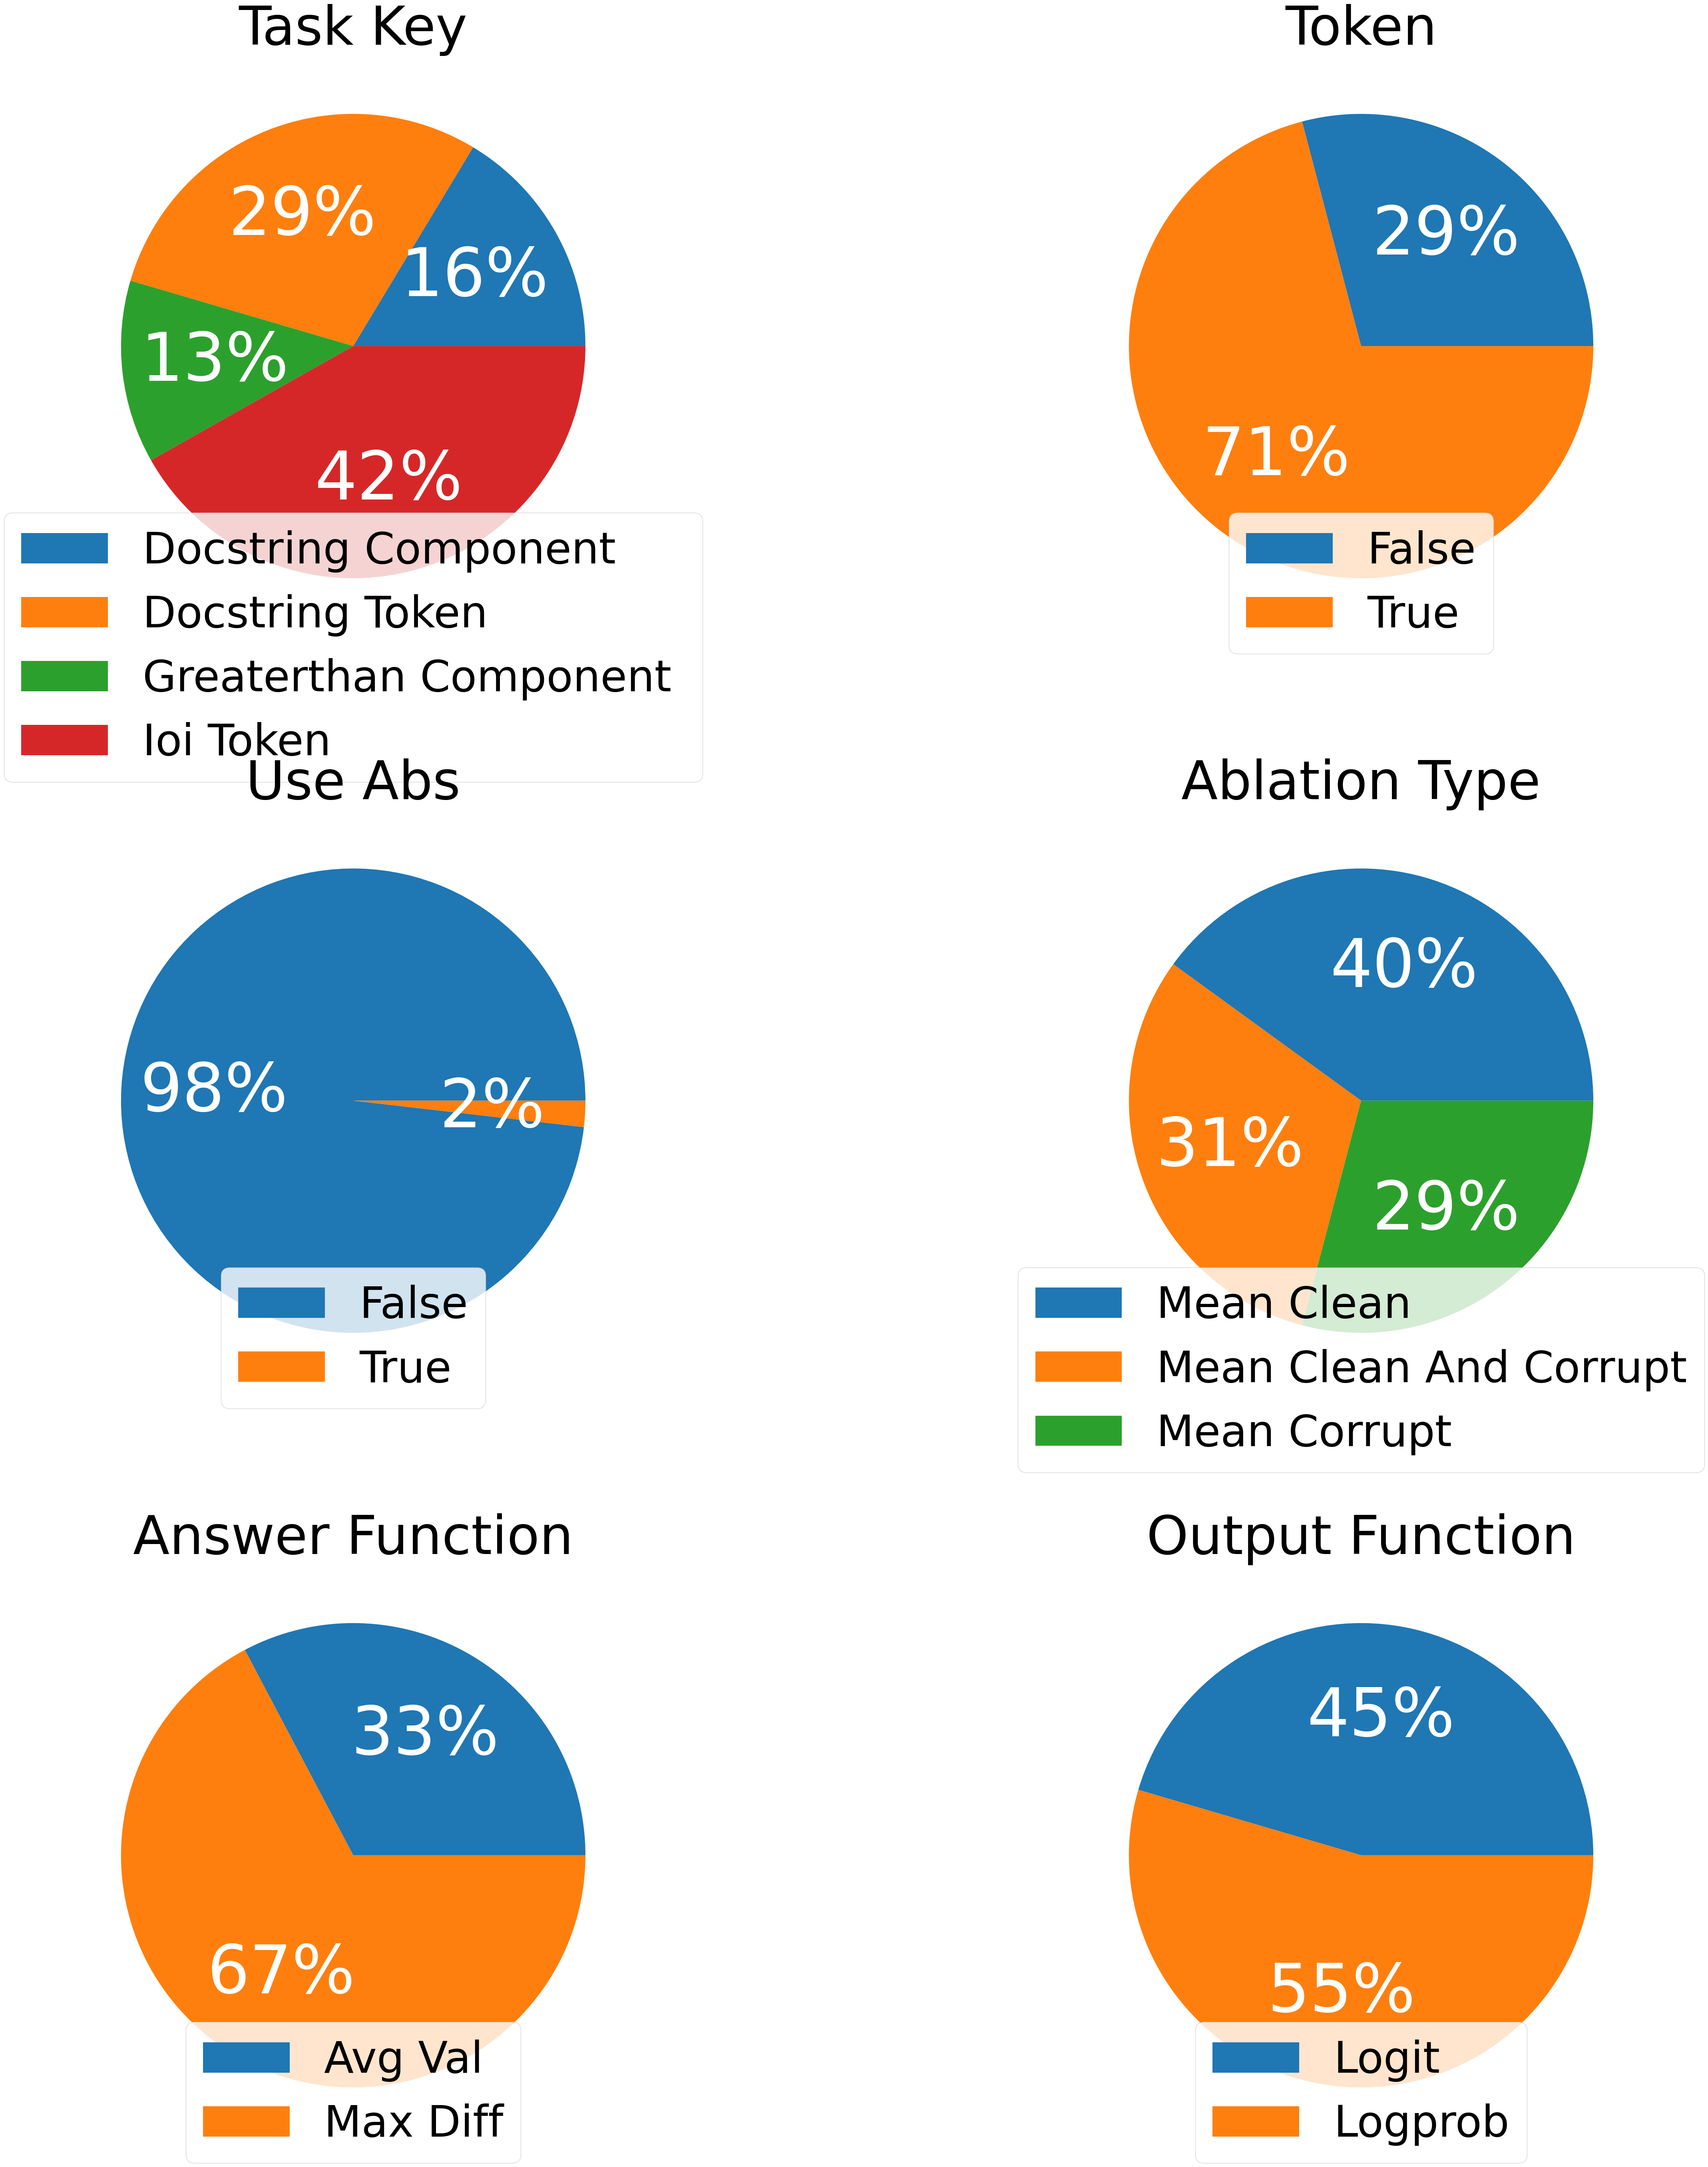

In [219]:
#TODO: make nice at to paper (I think we can basically keep it to this)
create_category_pie_charts(
    indep_and_true_minimal_df, 
    ignore_categories=['epsilon'],
    title="", #f"Fractions of ({len(indep_and_true_minimal_df)}) Minimal Complete Circuits", 
    figsize=(55, 55), 
    fontsize=120,
    n_cols=2,
    legend_bbox_to_anchor=(0.5, 0.25),
    hspace=0.3,
    # legend_fontsize=78,
    # cat_fontsize=96,
)

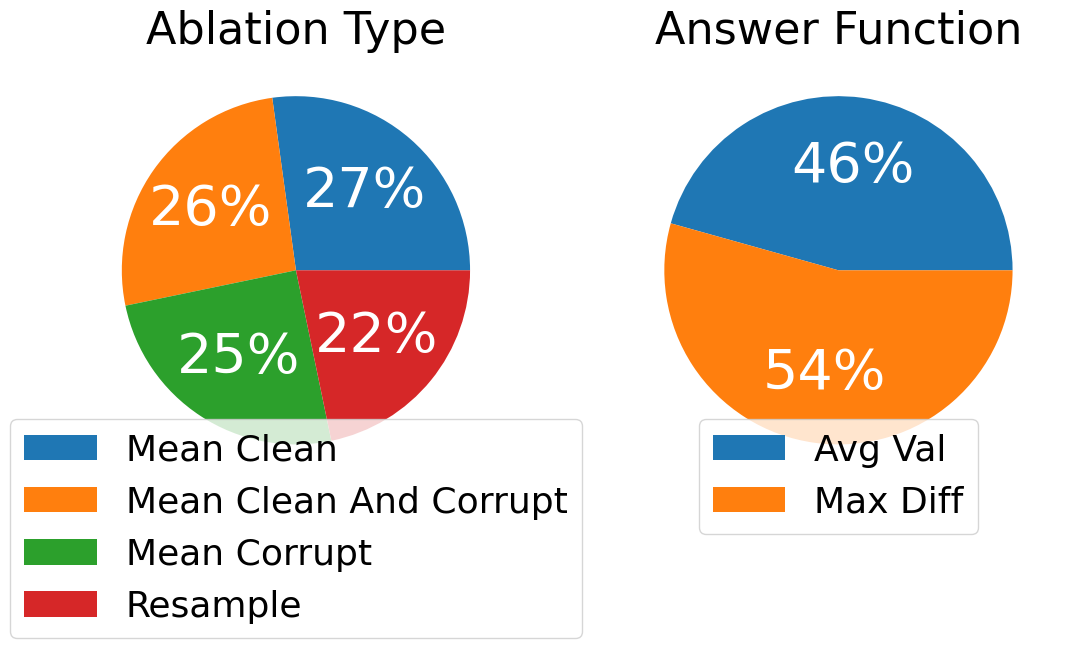

In [238]:
create_category_pie_charts(
    true_minimal_df, 
    ignore_categories=['task_key', 'token', 'use_abs', 'epsilon', 'grad_func'],
    title="", #f"Fractions of ({len(indep_and_true_minimal_df)}) Minimal Complete Circuits", 
    figsize=(11, 11), 
    fontsize=40, 
    legend_fontsize=26,
    cat_fontsize=32,
    n_cols=2,
    legend_bbox_to_anchor=(0.5, 0.2),
    hspace=0.4,
)

##  Minimality vs Independence 
(Not using for now)

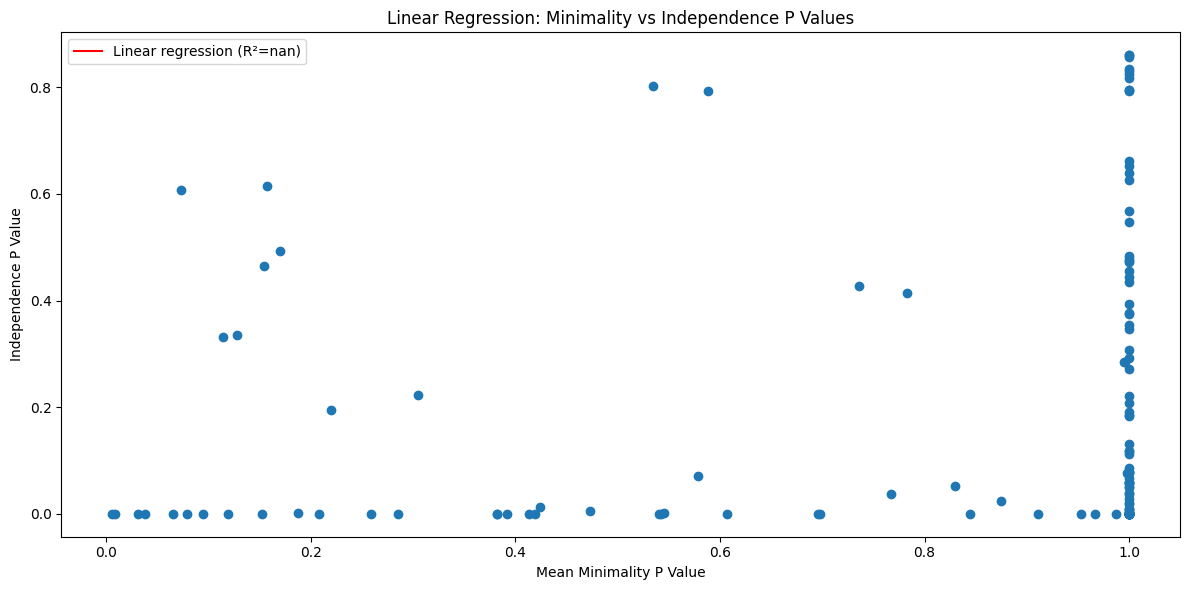

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# wait high p value for min implies minimal 
# high p value for indep implies independent
# Assuming df is already defined and contains the necessary data
df_sorted = df[df['frac_total_edges'] < 0.5]
df_sorted = df_sorted.sort_values('min_mean_p_value', ascending=False, inplace=False)

# filter p values > .95 out 
# df = df[df['min_mean_p_value'] < 0.95]

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot
ax.scatter(df_sorted['min_mean_p_value'], df_sorted['indep_p_value'])

# Calculate and plot linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['min_mean_p_value'], df['indep_p_value'])
line = slope * df['min_mean_p_value'] + intercept
ax.plot(df['min_mean_p_value'], line, color='r', label=f'Linear regression (R²={r_value**2:.3f})')

ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# ax.invert_xaxis()
# # ax.invert_yaxis()

ax.legend()
plt.title('Linear Regression: Minimality vs Independence P Values')
plt.tight_layout()
plt.show()

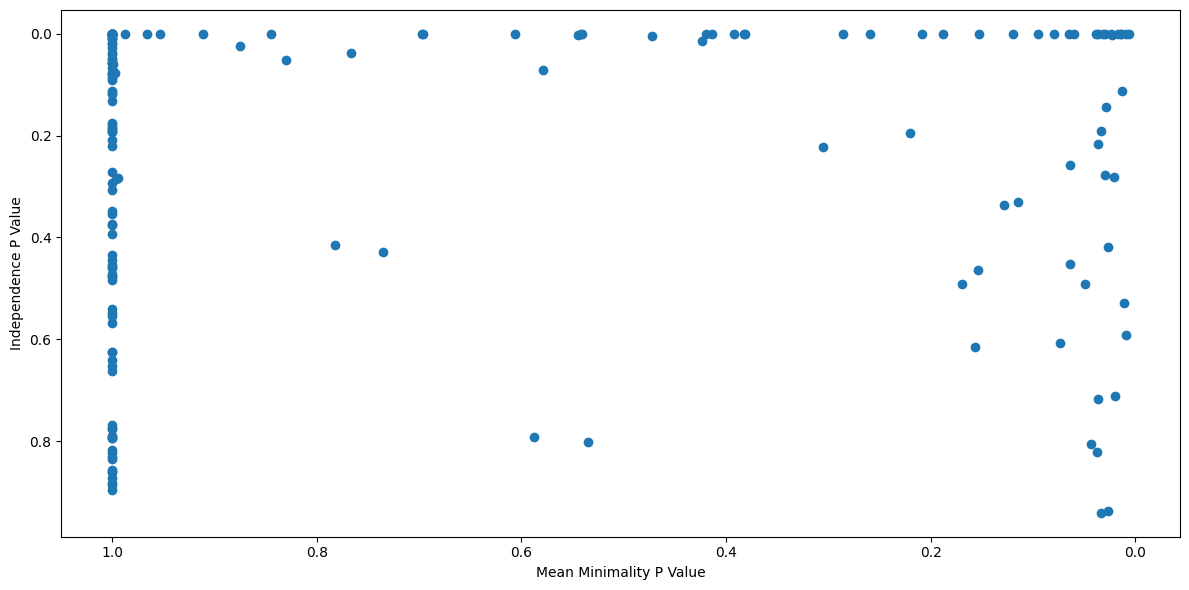

In [36]:
from scipy import stats

# sorted by minimality p value, plot independence p value
df = df.sort_values('min_mean_p_value', ascending=False, inplace=False)

# low min p value means not minimal 
# low independence p value means not independent
# plot min_mean_p_value on x axis and indep_p_value on y axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['min_mean_p_value'], df['indep_p_value'])
ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# invert x axis and y axis 
ax.invert_xaxis()
ax.invert_yaxis()
# plot trend line 
plt.tight_layout()
plt.show()